In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import plotly.express as px
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

from vincenty import vincenty

import optuna

In [2]:
data = pd.read_csv('kc_house_data.csv')

In [3]:
data.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [4]:
# Check data counts

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
# Check data scales

data.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000  
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652  
std       53.505026      0.138564      0.140828     685.391304   27304.179631  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [6]:
# Need for scaling identified and possible ouliers present

In [7]:
# Covert date feature into usable features

import datetime

data['date'] = pd.to_datetime(data.date)
data['date_day_of_week'] = data['date'].dt.dayofweek 
data['date_week'] = data['date'].dt.week
data['date_month'] = data['date'].dt.month
data['date_quarter'] = data['date'].dt.quarter 
data['date_year'] = data['date'].dt.year 

C:\Users\user\anaconda3-64\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [8]:
# Drop redundant features

data = data.drop(['id','date'], axis=1)

In [9]:
# Check feature distribution to determine scaling method

def diagnostic_plots(df, variable):
  plt.figure(figsize=(16,4))

  plt.subplot(1,3,1)
  sns.histplot(df[variable], bins=30, kde=True)
  plt.title(f'Histogram - {variable}')

  plt.subplot(1,3,2)
  stats.probplot(df[variable], dist='norm', plot=plt)
  plt.ylabel('RM Quantiles')
  plt.title(f'Q-Q Plot - {variable}')

  plt.subplot(1,3,3)
  sns.boxplot(y=df[variable])
  plt.title(f'Boxplot - {variable}')

  plt.show()

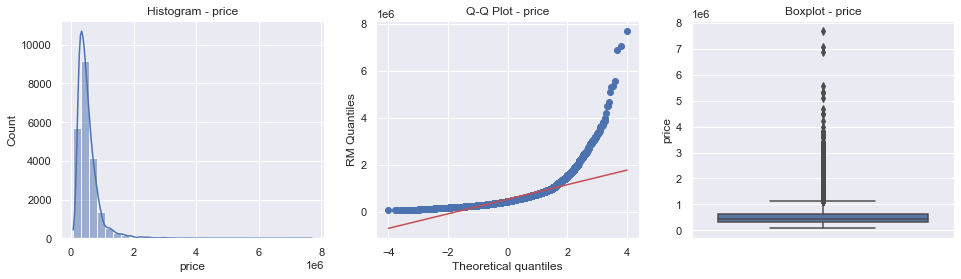

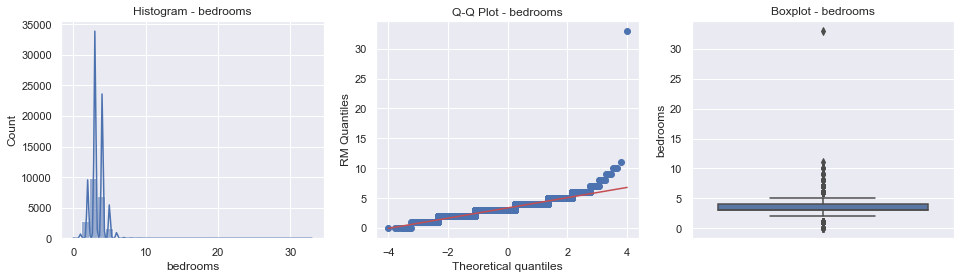

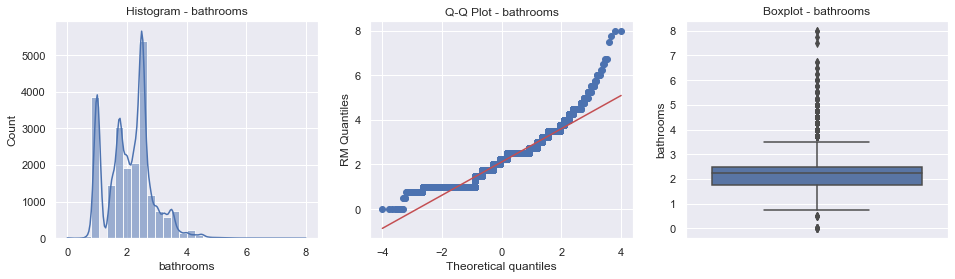

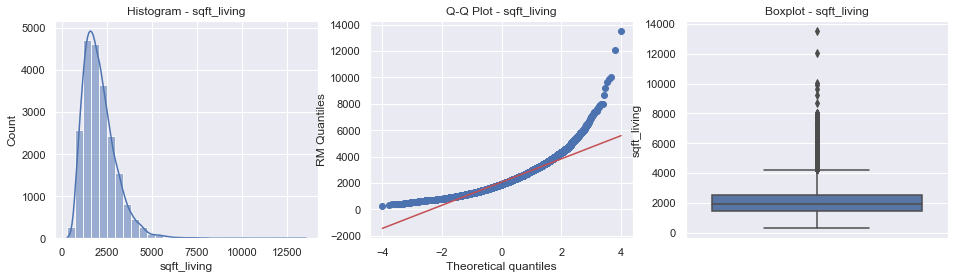

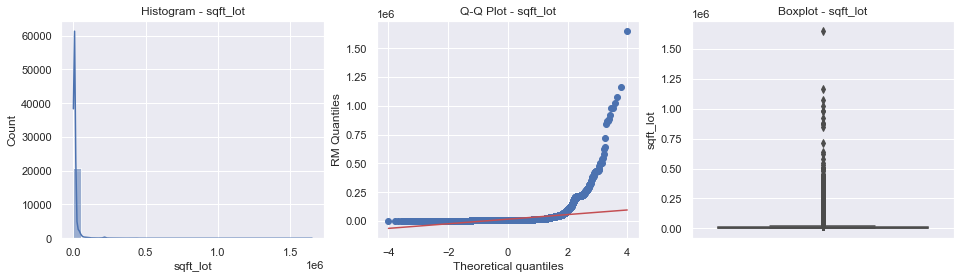

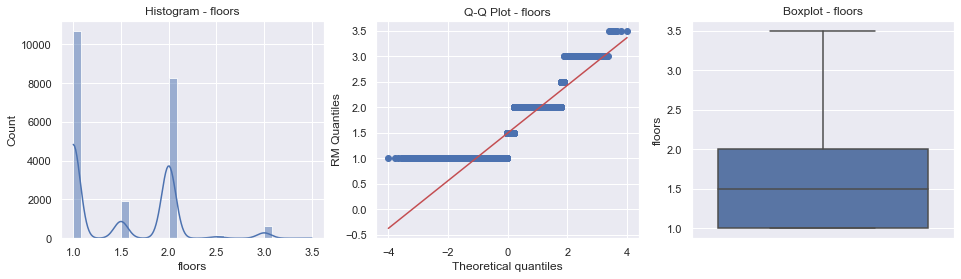

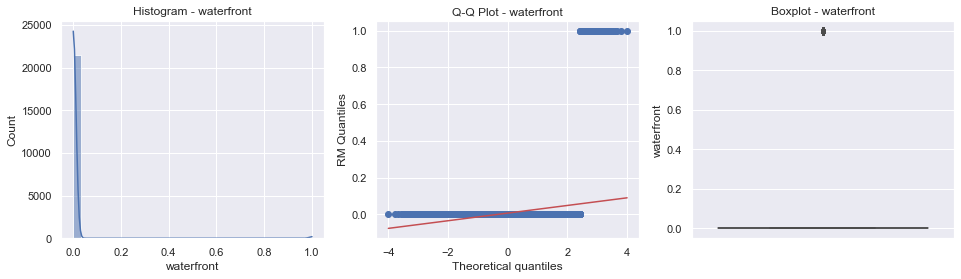

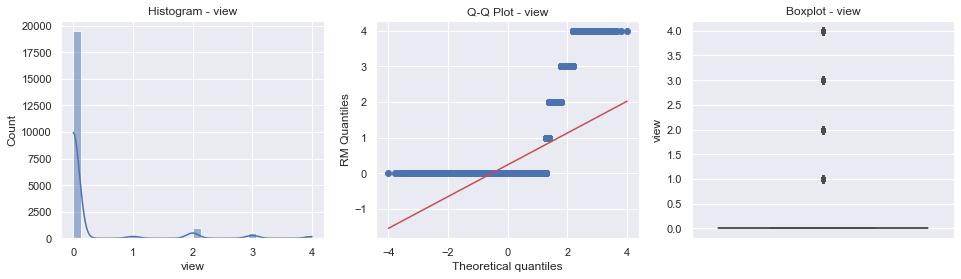

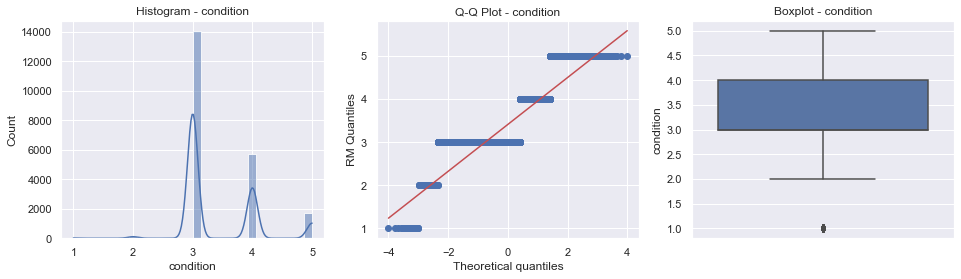

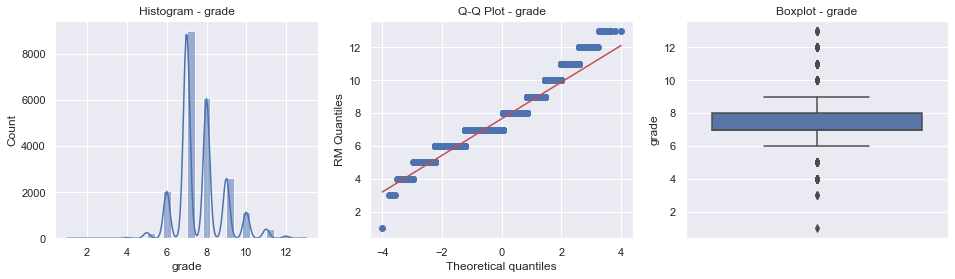

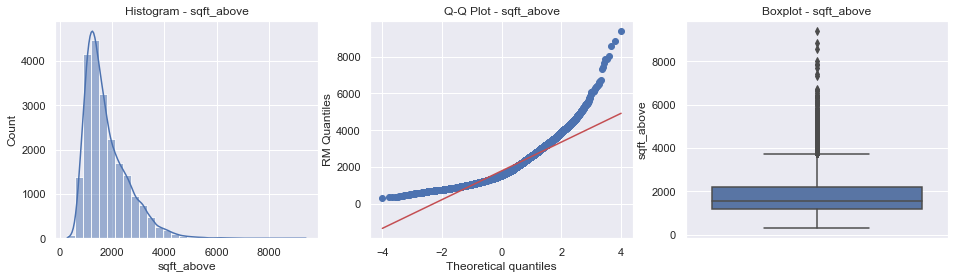

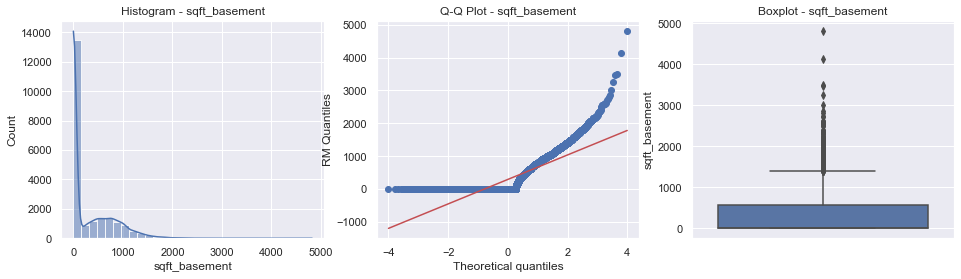

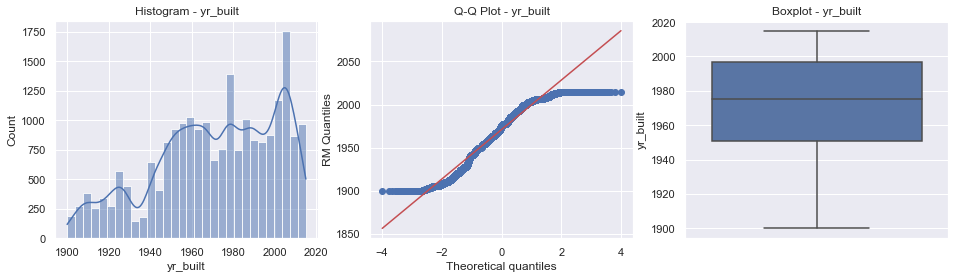

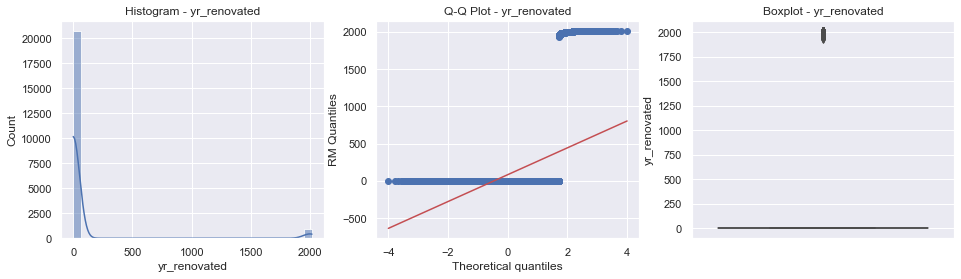

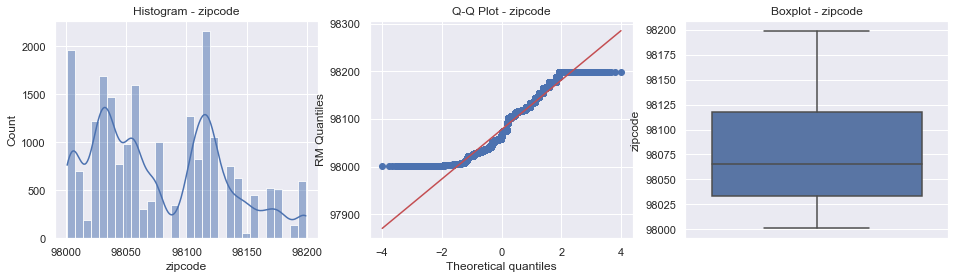

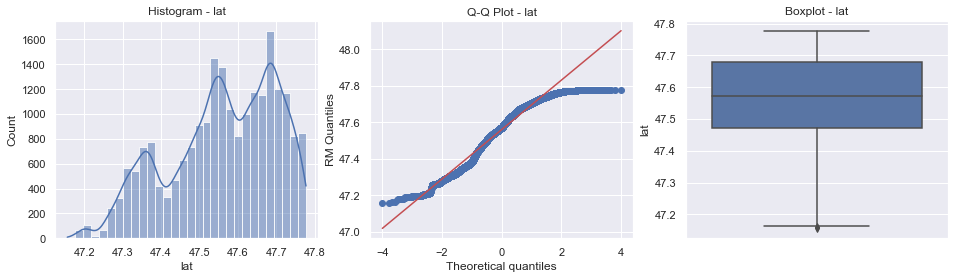

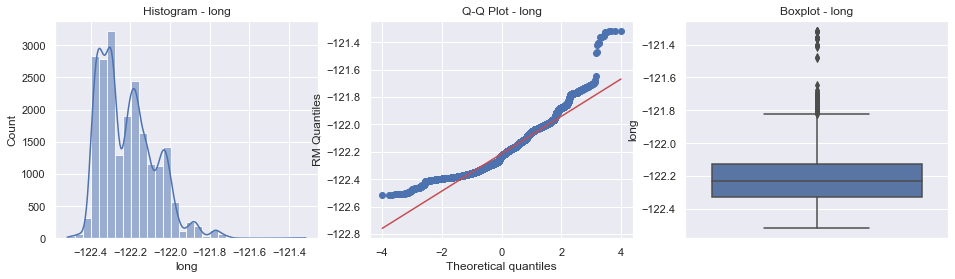

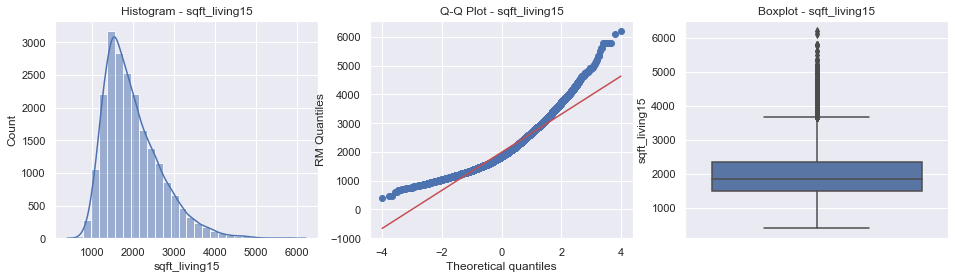

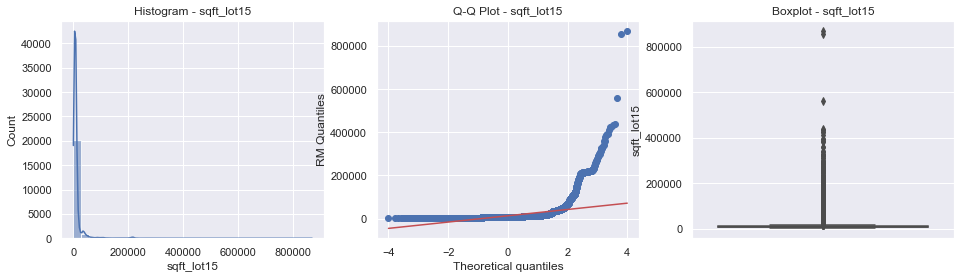

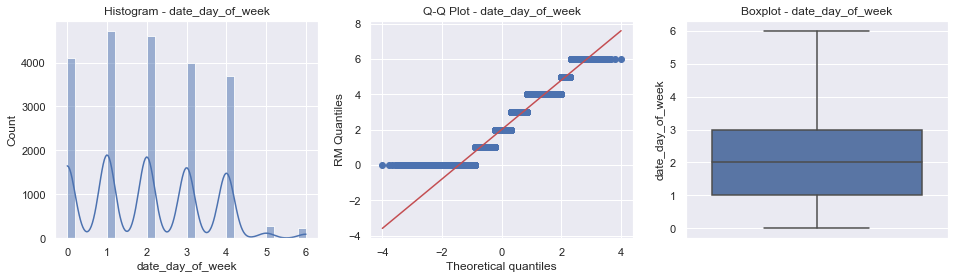

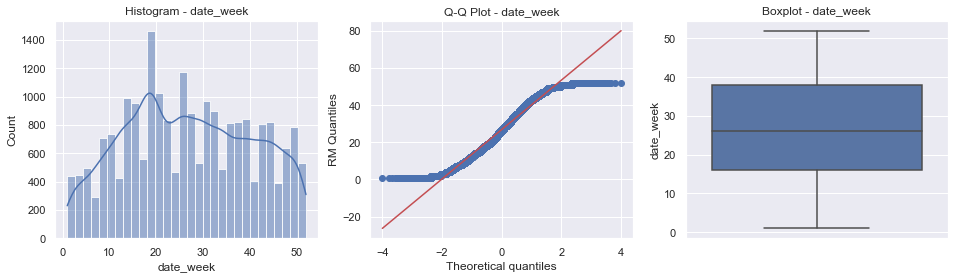

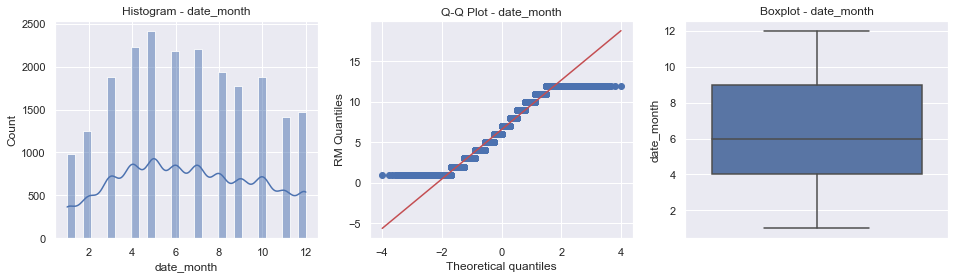

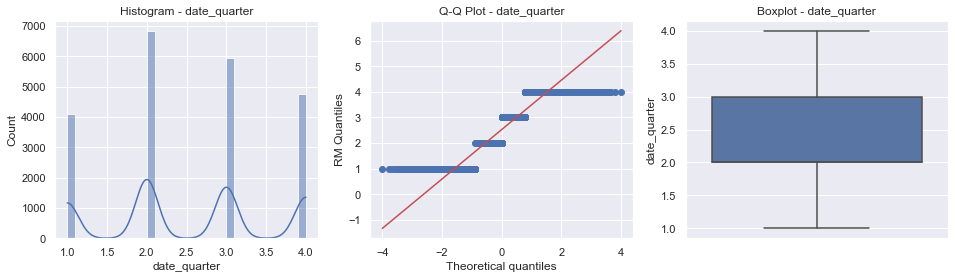

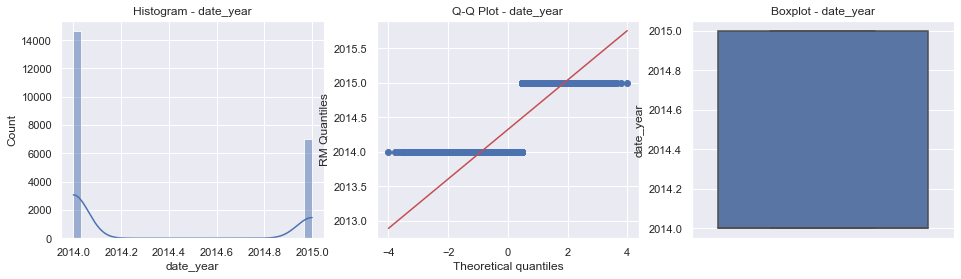

In [10]:
for i in range(data.shape[1]):
  diagnostic_plots(data, data.columns[i]) 

In [11]:
# Potential outliers with significant skew to select predictors and response variable

In [12]:
from feature_engine.outliers import OutlierTrimmer

trimmer = OutlierTrimmer(tail='both', fold=1.5, variables=['sqft_living','sqft_lot','sqft_above',
                                                           'sqft_basement','sqft_living15','sqft_lot15','long'])

data_trimmed = trimmer.fit_transform(data)

In [13]:
# Detect occurrance of zero values

zero_count = data[data==0].count()
zero_count[zero_count>0]

bedrooms               13
bathrooms              10
waterfront          21450
view                19489
sqft_basement       13126
yr_renovated        20699
date_day_of_week     4099
dtype: int64

In [14]:
# To eliminate data for 'bedrooms' and 'bathrooms' variable 
# For other variables zero values have discernable meaning so to retain

In [15]:
data_trimmed = data_trimmed.drop(data_trimmed[(data_trimmed['bedrooms']==0) | (data_trimmed['bathrooms']==0)].index)

In [16]:
# Check for multicollinearity (MC)

features = list(data_trimmed.corr().columns)

fig = px.imshow(data_trimmed.corr(), x=features, y=features, height=700, width=700)
fig.show()

In [17]:
# Predictors most correlated with price: 'sqft_living','sqft_living15' 'grade' and 'sqft_above'
# To further explore relationship between said variables

In [18]:
data_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15400 entries, 0 to 21612
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             15400 non-null  float64
 1   bedrooms          15400 non-null  int64  
 2   bathrooms         15400 non-null  float64
 3   sqft_living       15400 non-null  int64  
 4   sqft_lot          15400 non-null  int64  
 5   floors            15400 non-null  float64
 6   waterfront        15400 non-null  int64  
 7   view              15400 non-null  int64  
 8   condition         15400 non-null  int64  
 9   grade             15400 non-null  int64  
 10  sqft_above        15400 non-null  int64  
 11  sqft_basement     15400 non-null  int64  
 12  yr_built          15400 non-null  int64  
 13  yr_renovated      15400 non-null  int64  
 14  zipcode           15400 non-null  int64  
 15  lat               15400 non-null  float64
 16  long              15400 non-null  float6

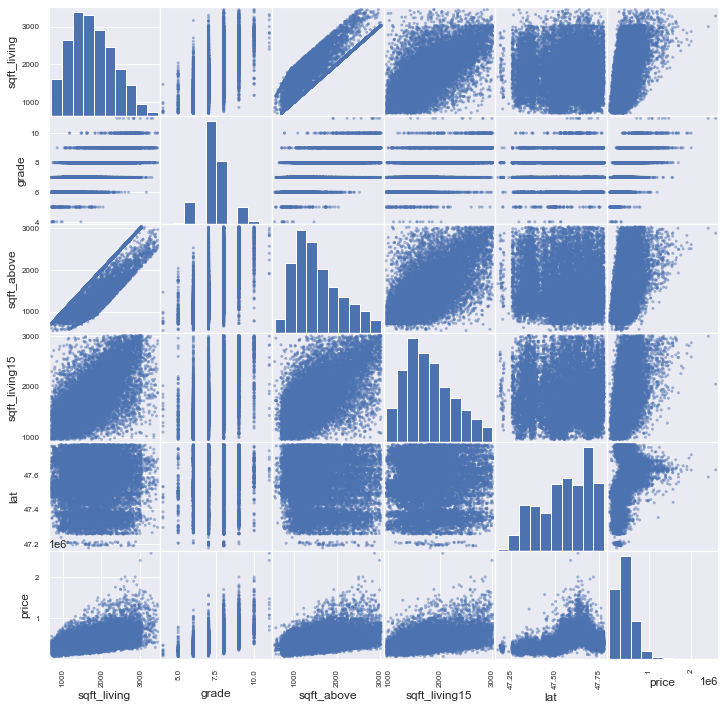

In [19]:
# Plot key predicators against response variable

price_corr_vars = data_trimmed[['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'lat', 'price']]

scatter_matrix(price_corr_vars, figsize=(12,12))
plt.show()

In [20]:
# Suggestion of positive linear relationship with price polynomial relationship 
# To apply log tranformation to 'price' to normalize distribution given skew

In [21]:
# Split data by features and target

X = data_trimmed.copy()
y = X.pop('price')

In [22]:
# Log transform response variable

y_log = np.log(y)

In [23]:
# Split into training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size = 0.2, random_state=42)

In [24]:
X_train.describe()

bedrooms     bathrooms   sqft_living      sqft_lot        floors  \
count  12320.000000  12320.000000  12320.000000  12320.000000  12320.000000   
mean       3.216477      1.945252   1764.520049   8284.214529      1.464692   
std        0.802709      0.658771    554.772584   7245.311540      0.549346   
min        1.000000      0.500000    710.000000    520.000000      1.000000   
25%        3.000000      1.500000   1330.000000   4693.500000      1.000000   
50%        3.000000      2.000000   1710.000000   7200.000000      1.000000   
75%        4.000000      2.500000   2150.000000   9450.000000      2.000000   
max       11.000000      5.250000   3450.000000  76877.000000      3.500000   

         waterfront          view     condition         grade    sqft_above  \
count  12320.000000  12320.000000  12320.000000  12320.000000  12320.000000   
mean       0.003571      0.134091      3.414773      7.387256   1565.164123   
std        0.059657      0.567004      0.646100      0.878133    548.312578   
min        0.000000      0.000000      1.000000      4.000000    550.000000   
25%        0.000000      0.000000      3.000000      7.000000   1140.000000   
50%        0.000000      0.000000      3.000000      7.000000   1440.000000   
75%        0.000000      0.000000      4.000000      8.000000   1920.000000   
max        1.000000      4.000000      5.000000     11.000000   3030.000000   

       ...       zipcode           lat          long  sqft_living15  \
count  ...  12320.000000  12320.000000  12320.000000   12320.000000   
mean   ...  98083.634497     47.558612   -122.244885    1791.801055   
std    ...     54.417087      0.141619      0.109880     463.914615   
min    ...  98001.000000     47.176400   -122.425000     960.000000   
25%    ...  98034.000000     47.454600   -122.339000    1440.000000   
50%    ...  98092.000000     47.572550   -122.277000    1720.000000   
75%    ...  98122.000000     47.681100   -122.167000    2090.000000   
max    ...  98199.000000     47.777600   -122.003000    3010.000000   

         sqft_lot15  date_day_of_week     date_week    date_month  \
count  12320.000000      12320.000000  12320.000000  12320.000000   
mean    7847.734984          2.009984     26.887419      6.565828   
std     5849.526300          1.462683     13.546434      3.127050   
min      651.000000          0.000000      1.000000      1.000000   
25%     4800.000000          1.000000     16.000000      4.000000   
50%     7260.000000          2.000000     26.000000      6.000000   
75%     9020.750000          3.000000     38.000000      9.000000   
max    53578.000000          6.000000     52.000000     12.000000   

       date_quarter     date_year  
count  12320.000000  12320.000000  
mean       2.522727   2014.329302  
std        1.039586      0.469979  
min        1.000000   2014.000000  
25%        2.000000   2014.000000  
50%        2.000000   2014.000000  
75%        3.000000   2015.000000  
max        4.000000   2015.000000  

[8 rows x 23 columns]

In [25]:
# Apply scaling
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [26]:
### Baseline Modelling ####

def model(type): 
    model = type
    model.fit(scaled_X_train,y_train)

    y_test_pred = model.predict(scaled_X_test)

    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

    r2_test = r2_score(y_test, y_test_pred)
    n = len(y_test)
    p = len(X_test.columns)

    adjusted_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

    model_name = model.__class__.__name__
    print(f'{model_name} -> RMSE: {rmse_test.round(4)}; R2: {r2_test.round(4)}; ADJ R2: {adjusted_r2_test.round(4)}')

    residuals_df = pd.DataFrame()
    residuals_df['Predicted Price'] = y_test_pred
    residuals_df['Actual Price'] = y_test
    
    return sns.residplot(data=residuals_df, x='Predicted Price', y='Actual Price')

LinearRegression -> RMSE: 0.239; R2: 0.7136; ADJ R2: 0.7114


<AxesSubplot:xlabel='Predicted Price', ylabel='Actual Price'>

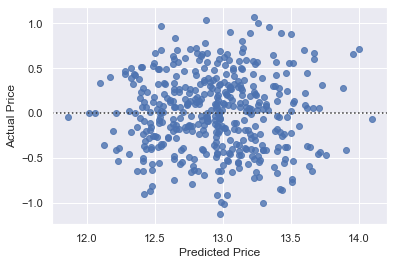

In [27]:
model(LinearRegression())

DecisionTreeRegressor -> RMSE: 0.2451; R2: 0.6987; ADJ R2: 0.6964


<AxesSubplot:xlabel='Predicted Price', ylabel='Actual Price'>

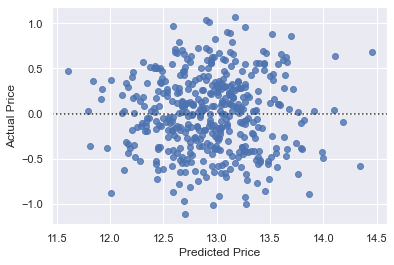

In [28]:
model(DecisionTreeRegressor())

In [29]:
###### Feature Engineering ######

In [30]:
data_fe = data_trimmed.copy()

In [31]:
data_fe.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  ...  zipcode      lat     long  sqft_living15  \
0     0          3      7  ...    98178  47.5112 -122.257           1340   
1     0          3      7  ...    98125  47.7210 -122.319           1690   
2     0          3      6  ...    98028  47.7379 -122.233           2720   
3     0          5      7  ...    98136  47.5208 -122.393           1360   
4     0          3      8  ...    98074  47.6168 -122.045           1800   

   sqft_lot15  date_day_of_week  date_week  date_month  date_quarter  \
0        5650                 0         42          10             4   
1        7639                 1         50          12             4   
2        8062                 2          9           2             1   
3        5000                 1         50          12             4   
4        7503                 2          8           2             1   

   date_year  
0       2014  
1       2014  
2       2015  
3       2014  
4       2015  

[5 rows x 24 columns]

In [126]:
temp_df = data_fe.copy()

In [130]:
features_to_bin = ['sqft_living','sqft_lot','sqft_above','sqft_basement',
                   'sqft_living15','sqft_lot15','yr_built','yr_renovated',
                   'long','lat','zipcode']

for i in features_to_bin:
    temp_df[i+'_binned'] = pd.cut(temp_df[i],6)

In [131]:
binned_features = [x + '_binned' for x in features_to_bin]

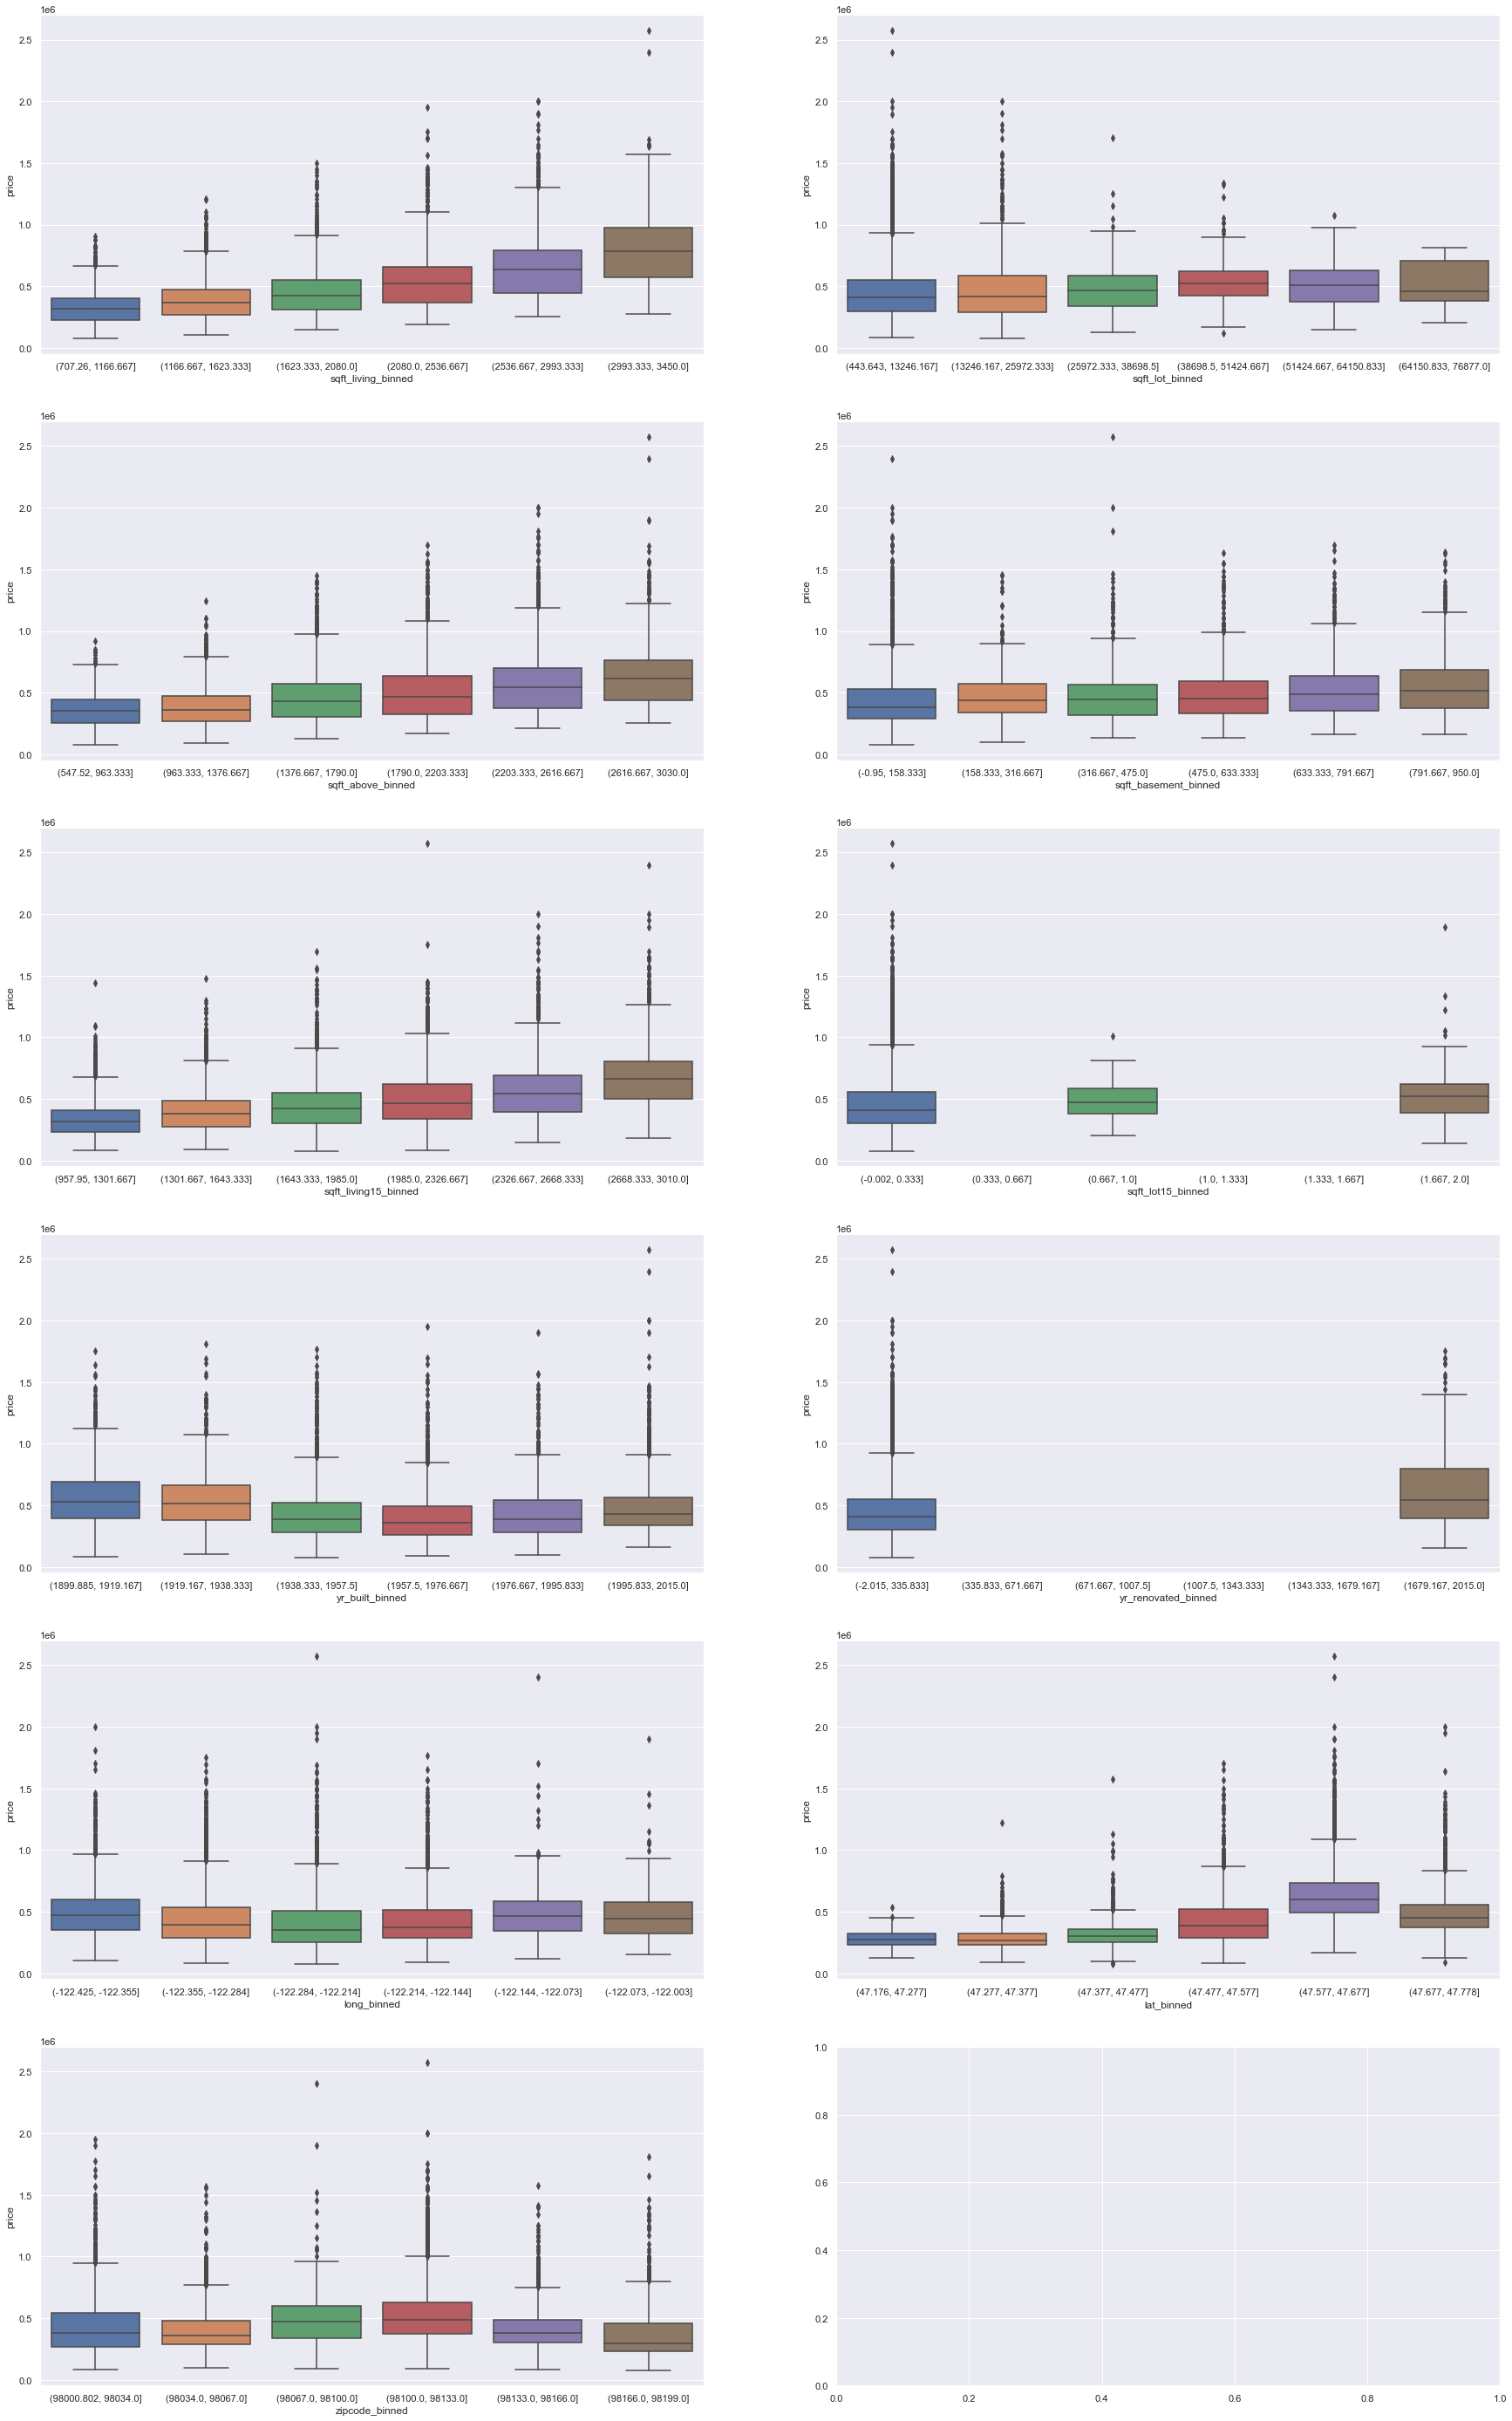

In [132]:
fig,ax = plt.subplots(6,2,figsize=(30,50),sharey=False)
axes=ax.flatten()

for i in range(11):
    sns.boxplot(data=temp_df, x=temp_df[binned_features[i]], y='price', ax=axes[i])

In [36]:
# Clusters identified 'sqft_lot', 'sqft_basement', 'sqft_lot15', 'yr_built',
# 'yr_renovated', 'long', 'lat', 'zipcode'

In [37]:
# 'sqft_lot' variable

data_fe['sqft_lot_binned'] = temp_df.sqft_lot.apply(lambda x: 0 if x>324358.333 else(
                                                    1 if x<65287.667 or (x>130055.333 and x<194823) 
                                                    or x>259590.667 else 2))

In [38]:
# 'sqft_basement' variable

data_fe['sqft_basement_binned'] = temp_df.sqft_basement.apply(lambda x: 0 if x<158.333 else(
                                                              1 if x<633.333 else 2))

In [39]:
# 'sqft_lot15' variable

data_fe['sqft_lot15'] = temp_df.sqft_lot15.apply(lambda x: 0 if x<27114.5 else(
                                                 1 if x>44756.833 else 2))

In [40]:
# 'yr_built' variable 
# To convert to 'property age' variable

temp_df['property_age'] = temp_df.yr_built.apply(lambda x: 2022-x)
temp_df['age_binned'] = pd.cut(temp_df['property_age'],6)
temp_df['age_binned'].unique()

[(64.5, 83.667], (83.667, 102.833], (45.333, 64.5], (26.167, 45.333], (6.885, 26.167], (102.833, 122.0]]
Categories (6, interval[float64, right]): [(6.885, 26.167] < (26.167, 45.333] < (45.333, 64.5] < (64.5, 83.667] < (83.667, 102.833] < (102.833, 122.0]]

<AxesSubplot:xlabel='age_binned', ylabel='price'>

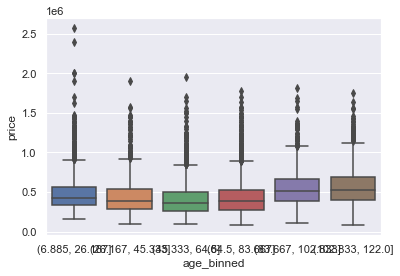

In [41]:
sns.boxplot(data=temp_df, x='age_binned', y='price')

In [42]:
data_fe['under_80_yrs_old'] = temp_df.property_age.apply(lambda x: 1 if x<80 else 0)

In [43]:
### 'yr_renovated'

In [44]:
data_fe['yr_renovated'].unique()

array([   0, 1991, 2002, 2010, 1994, 1978, 2005, 2003, 1984, 2014, 2011,
       1974, 1983, 2013, 1945, 1990, 1988, 1957, 1977, 1981, 1995, 2000,
       1999, 1970, 1986, 1992, 2009, 2004, 2007, 1987, 1973, 1985, 2001,
       1980, 1971, 1979, 1997, 1969, 2006, 1948, 2015, 2008, 1989, 1968,
       1963, 1993, 1962, 1972, 1953, 1998, 1996, 1982, 1950, 1940, 1976,
       2012, 1946, 1975, 1958, 1955, 1959, 1960, 1967, 1934, 1965, 1944,
       1964], dtype=int64)

In [45]:
# To differentiate properties renovated from those not with binary indicator variable

In [46]:
data_fe['undergone_renovation'] = data_fe['yr_renovated'].apply(lambda x: 0 if x==0 else 1)

In [47]:
### 'lat' and 'long' variables
# To calculate property distance from Seattle(47.608013,-122.335167) 

coords = temp_df[['lat','long']].apply(list, axis=1)

def closest_point(property_locations, city_location):
    distance_to_seattle = []
    for property_location in property_locations:
        distance = vincenty(property_location, city_location)
        distance_to_seattle.append(distance)
    return distance_to_seattle

temp_df['distance'] = closest_point(coords, [47.608013,-122.335167])
temp_df['distance_binned'] = pd.cut(temp_df['distance'],6)
temp_df['distance_binned'].unique()

[(9.942, 18.626], (18.626, 27.31], (27.31, 35.994], (1.206, 9.942], (35.994, 44.678], (44.678, 53.362]]
Categories (6, interval[float64, right]): [(1.206, 9.942] < (9.942, 18.626] < (18.626, 27.31] < (27.31, 35.994] < (35.994, 44.678] < (44.678, 53.362]]

<AxesSubplot:xlabel='distance_binned', ylabel='price'>

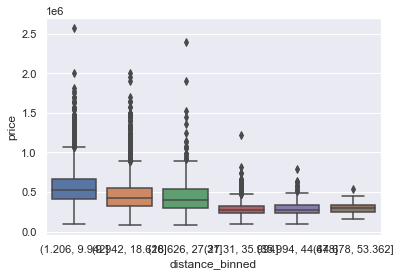

In [48]:
sns.boxplot(data=temp_df, x='distance_binned', y='price')

In [49]:
# 3 clear segmnets illustrated -> to create indicator variable accordingly

In [50]:
data_fe['distance_to_seattle'] = temp_df.distance.apply(lambda x: 0 if x<9.942 else
                                                        (1 if x<27.31 else 2))

In [51]:
# Bin 'lat' and 'long' variables

data_fe['lat_binned'] = data_fe.lat.apply(lambda x: 0 if x<47.477 else (1 if x<47.577 or x>47.677 else 2))
data_fe['long_binned'] = data_fe.long.apply(lambda x: 0 if x<-122.355 or x>-122.144 else 1)

In [52]:
### 'zipcode' variable

data_fe['zipcode_binned'] = temp_df.zipcode.apply(lambda x: 0 if 98067<x<98133 else 1)

In [53]:
# Drop superfluous date-related variables

data_fe = data_fe.drop(['date_quarter','date_month'],axis=1)

In [54]:
# Re-split data, log tranform response variable and apply scaling

X = data_fe.copy()
y = X.pop('price')

y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size = 0.2, random_state=42)

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

LinearRegression -> RMSE: 0.2034; R2: 0.7925; ADJ R2: 0.7905


<AxesSubplot:xlabel='Predicted Price', ylabel='Actual Price'>

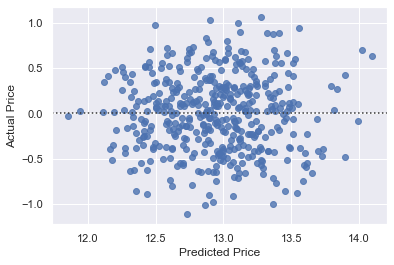

In [55]:
## Linear Regession
model(LinearRegression())

In [56]:
# Significant improvement in metrics from feature engineering
# 'distance_to_seattle' variable addition provided greatest increase in scoring

DecisionTreeRegressor -> RMSE: 0.2372; R2: 0.7177; ADJ R2: 0.715


<AxesSubplot:xlabel='Predicted Price', ylabel='Actual Price'>

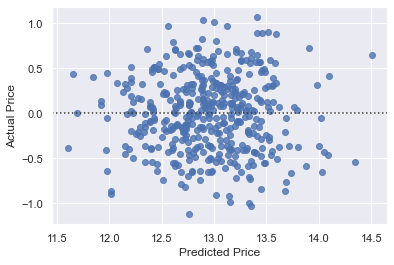

In [57]:
## Decision Tree
model(DecisionTreeRegressor())

In [58]:
def poly_model(degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    
    y_log = np.log(y)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y_log, test_size=0.2, random_state=42)

    model(LinearRegression())

LinearRegression -> RMSE: 0.2034; R2: 0.7925; ADJ R2: 0.7905


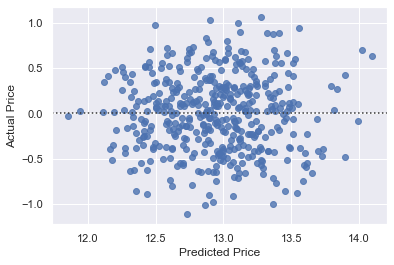

In [59]:
poly_model(2)

In [60]:
# No benefit from polynomial modelling

In [61]:
from sklearn.ensemble import GradientBoostingRegressor as gb
from lightgbm import LGBMRegressor as lgbm
from xgboost import XGBRegressor as xg

def boost_models(x):
    y_log = np.log(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    x.fit(scaled_X_train, y_train)
    yhat = x.predict(scaled_X_test)
    
    rmse_test = mean_squared_error(y_test, yhat, squared=False)

    r2_test = r2_score(y_test, yhat)
    n = len(y_test)
    p = len(X_test.columns)

    adjusted_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
    
    algoname = x.__class__.__name__
    
    return algoname, rmse_test.round(4), r2_test.round(4), adjusted_r2_test.round(4)

algo = [gb(), lgbm(), xg()]
score = []

for a in algo:
    score.append(boost_models(a))

pd.DataFrame(score, columns=['Model', 'RMSE', 'R2', 'ADJ R2'])

Model    RMSE      R2  ADJ R2
0  GradientBoostingRegressor  0.1726  0.8506  0.8492
1              LGBMRegressor  0.1586  0.8738  0.8726
2               XGBRegressor  0.1614  0.8693  0.8680

In [1134]:
# Hyperparameter tuning of xgboost and lgbm models using Optuna

import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    models = ['xg', 'lgbm']
    score=[]
    
    for model in models:
        if model == 'xg':
            param = {
                'max_depth': trial.suggest_int('max_depth_xg', 1, 10),
                'learning_rate': trial.suggest_float('learning_rate_xg', 0.01, 1.0),
                'n_estimators': trial.suggest_int('n_estimators_xg', 50, 1000),
                'min_child_weight': trial.suggest_int('min_child_weight_xg', 1, 10),
                'gamma': trial.suggest_float('gamma_xg', 0.01, 1.0),
                'subsample': trial.suggest_float('subsample_xg', 0.01, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree_xg', 0.01, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha_xg', 0.01, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda_xg', 0.01, 1.0),
                'random_state': trial.suggest_int('random_state_xg', 1, 1000)
            }
            algo = xg(**param)
            
        if model == 'lgbm':
            param = {
                'num_leaves': trial.suggest_int('num_leaves_lgbm', 1, 50),
                'max_depth': trial.suggest_int('max_depth_lgbm', -100, -1),
                'learning_rate': trial.suggest_uniform('learning_rate_lgbm', 0.01, 1),
                'n_estimators': trial.suggest_int('n_estimators_lgbm', 50, 500),
            }
            algo = lgbm(**param)

        y_log = np.log(y)
        X_train, X_test, y_train, y_test=train_test_split(X, y_log, test_size=0.2, random_state=42)
        
        scaler = StandardScaler()
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)
        
        algo.fit(scaled_X_train, y_train)
        yhat = algo.predict(scaled_X_test)

        r2_test = r2_score(y_test, yhat)
        n = len(y_test)
        p = len(X_test.columns)

        adjusted_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
        score.append(adjusted_r2_test.round(4))

    return max(score)

In [1135]:
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2022-12-05 17:05:14,591] A new study created in memory with name: regression
[I 2022-12-05 17:05:21,503] Trial 0 finished with value: 0.8664 and parameters: {'max_depth_xg': 9, 'learning_rate_xg': 0.2365260286218869, 'n_estimators_xg': 826, 'min_child_weight_xg': 2, 'gamma_xg': 0.522017490069975, 'subsample_xg': 0.37725725101574653, 'colsample_bytree_xg': 0.474940606730171, 'reg_alpha_xg': 0.8301289244688405, 'reg_lambda_xg': 0.9140683150196233, 'random_state_xg': 562, 'num_leaves_lgbm': 26, 'max_depth_lgbm': -25, 'learning_rate_lgbm': 0.22967829977052354, 'n_estimators_lgbm': 430}. Best is trial 0 with value: 0.8664.
[I 2022-12-05 17:05:22,588] Trial 1 finished with value: 0.8271 and parameters: {'max_depth_xg': 5, 'learning_rate_xg': 0.8087838915968787, 'n_estimators_xg': 196, 'min_child_weight_xg': 8, 'gamma_xg': 0.804701436899628, 'subsample_xg': 0.05546193997345317, 'colsample_bytree_xg': 0.7608424122193458, 'reg_alpha_xg': 0.4691020575690864, 'reg_lambda_xg': 0.376889628330777

[I 2022-12-05 17:06:10,409] Trial 15 finished with value: 0.8409 and parameters: {'max_depth_xg': 7, 'learning_rate_xg': 0.6465473464641904, 'n_estimators_xg': 421, 'min_child_weight_xg': 3, 'gamma_xg': 0.9856168583877317, 'subsample_xg': 0.6488646867409702, 'colsample_bytree_xg': 0.33682051201394597, 'reg_alpha_xg': 0.0943877241635411, 'reg_lambda_xg': 0.2876913974279615, 'random_state_xg': 185, 'num_leaves_lgbm': 42, 'max_depth_lgbm': -60, 'learning_rate_lgbm': 0.5007467282758465, 'n_estimators_lgbm': 137}. Best is trial 14 with value: 0.8737.
[I 2022-12-05 17:06:15,140] Trial 16 finished with value: 0.8737 and parameters: {'max_depth_xg': 9, 'learning_rate_xg': 0.9706752008823181, 'n_estimators_xg': 660, 'min_child_weight_xg': 5, 'gamma_xg': 0.849553640052819, 'subsample_xg': 0.7563875722590876, 'colsample_bytree_xg': 0.24525970135563951, 'reg_alpha_xg': 0.28508213761589546, 'reg_lambda_xg': 0.06050734649102052, 'random_state_xg': 152, 'num_leaves_lgbm': 36, 'max_depth_lgbm': -85, '

[I 2022-12-05 17:07:04,973] Trial 30 finished with value: 0.8566 and parameters: {'max_depth_xg': 10, 'learning_rate_xg': 0.3132793369062037, 'n_estimators_xg': 944, 'min_child_weight_xg': 10, 'gamma_xg': 0.5972313262122293, 'subsample_xg': 0.2889163027555963, 'colsample_bytree_xg': 0.13899883193529522, 'reg_alpha_xg': 0.37378577935179236, 'reg_lambda_xg': 0.3536521571179673, 'random_state_xg': 270, 'num_leaves_lgbm': 46, 'max_depth_lgbm': -40, 'learning_rate_lgbm': 0.38820318617139365, 'n_estimators_lgbm': 313}. Best is trial 20 with value: 0.8759.
[I 2022-12-05 17:07:07,722] Trial 31 finished with value: 0.8734 and parameters: {'max_depth_xg': 9, 'learning_rate_xg': 0.703501713750683, 'n_estimators_xg': 936, 'min_child_weight_xg': 7, 'gamma_xg': 0.9127241735353272, 'subsample_xg': 0.3289833328160444, 'colsample_bytree_xg': 0.01515227055380116, 'reg_alpha_xg': 0.4077940395862307, 'reg_lambda_xg': 0.4550409290477057, 'random_state_xg': 62, 'num_leaves_lgbm': 42, 'max_depth_lgbm': -1, '

[I 2022-12-05 17:08:09,511] Trial 45 finished with value: 0.8746 and parameters: {'max_depth_xg': 7, 'learning_rate_xg': 0.8747438250606026, 'n_estimators_xg': 947, 'min_child_weight_xg': 6, 'gamma_xg': 0.7330138337686528, 'subsample_xg': 0.8995630407739976, 'colsample_bytree_xg': 0.4380356285057092, 'reg_alpha_xg': 0.25303140351028564, 'reg_lambda_xg': 0.41503449353834015, 'random_state_xg': 690, 'num_leaves_lgbm': 37, 'max_depth_lgbm': -10, 'learning_rate_lgbm': 0.09839272183066891, 'n_estimators_lgbm': 303}. Best is trial 20 with value: 0.8759.
[I 2022-12-05 17:08:15,949] Trial 46 finished with value: 0.8389 and parameters: {'max_depth_xg': 6, 'learning_rate_xg': 0.8790719887970703, 'n_estimators_xg': 755, 'min_child_weight_xg': 6, 'gamma_xg': 0.6219407569381515, 'subsample_xg': 0.900691782838346, 'colsample_bytree_xg': 0.6796015918666499, 'reg_alpha_xg': 0.15578402574719502, 'reg_lambda_xg': 0.011604761605669478, 'random_state_xg': 708, 'num_leaves_lgbm': 35, 'max_depth_lgbm': -35,

[I 2022-12-05 17:09:16,203] Trial 60 finished with value: 0.85 and parameters: {'max_depth_xg': 5, 'learning_rate_xg': 0.9227189803420328, 'n_estimators_xg': 577, 'min_child_weight_xg': 5, 'gamma_xg': 0.2296643068351488, 'subsample_xg': 0.6507993488872416, 'colsample_bytree_xg': 0.6177131823757802, 'reg_alpha_xg': 0.11862975050586119, 'reg_lambda_xg': 0.7008385681261037, 'random_state_xg': 921, 'num_leaves_lgbm': 18, 'max_depth_lgbm': -44, 'learning_rate_lgbm': 0.012177209492724377, 'n_estimators_lgbm': 334}. Best is trial 52 with value: 0.8763.
[I 2022-12-05 17:09:18,492] Trial 61 finished with value: 0.8758 and parameters: {'max_depth_xg': 3, 'learning_rate_xg': 0.8063305579803173, 'n_estimators_xg': 451, 'min_child_weight_xg': 6, 'gamma_xg': 0.41107664339361594, 'subsample_xg': 0.7058197121670668, 'colsample_bytree_xg': 0.2808539198259525, 'reg_alpha_xg': 0.019805307482858737, 'reg_lambda_xg': 0.5159229960959535, 'random_state_xg': 876, 'num_leaves_lgbm': 29, 'max_depth_lgbm': -64, 

[I 2022-12-05 17:09:56,892] Trial 75 finished with value: 0.8744 and parameters: {'max_depth_xg': 6, 'learning_rate_xg': 0.6773818181654304, 'n_estimators_xg': 513, 'min_child_weight_xg': 6, 'gamma_xg': 0.33053924990411154, 'subsample_xg': 0.6392803835833678, 'colsample_bytree_xg': 0.26642884910878367, 'reg_alpha_xg': 0.07662457447471377, 'reg_lambda_xg': 0.5142119484517538, 'random_state_xg': 942, 'num_leaves_lgbm': 29, 'max_depth_lgbm': -52, 'learning_rate_lgbm': 0.09138185377308192, 'n_estimators_lgbm': 378}. Best is trial 52 with value: 0.8763.
[I 2022-12-05 17:09:59,294] Trial 76 finished with value: 0.8721 and parameters: {'max_depth_xg': 4, 'learning_rate_xg': 0.8083958056063597, 'n_estimators_xg': 398, 'min_child_weight_xg': 7, 'gamma_xg': 0.061319543379563524, 'subsample_xg': 0.6035952168957225, 'colsample_bytree_xg': 0.4155500328480715, 'reg_alpha_xg': 0.05328743110454935, 'reg_lambda_xg': 0.36352549402765855, 'random_state_xg': 861, 'num_leaves_lgbm': 6, 'max_depth_lgbm': -7

[I 2022-12-05 17:10:51,898] Trial 90 finished with value: 0.8744 and parameters: {'max_depth_xg': 4, 'learning_rate_xg': 0.22198021219355374, 'n_estimators_xg': 846, 'min_child_weight_xg': 6, 'gamma_xg': 0.5748651490777884, 'subsample_xg': 0.4903579488065021, 'colsample_bytree_xg': 0.39439034219548674, 'reg_alpha_xg': 0.05746614841765598, 'reg_lambda_xg': 0.36407707586906746, 'random_state_xg': 443, 'num_leaves_lgbm': 11, 'max_depth_lgbm': -53, 'learning_rate_lgbm': 0.12286765968596233, 'n_estimators_lgbm': 324}. Best is trial 78 with value: 0.8764.
[I 2022-12-05 17:10:54,360] Trial 91 finished with value: 0.8749 and parameters: {'max_depth_xg': 3, 'learning_rate_xg': 0.8169760461697277, 'n_estimators_xg': 387, 'min_child_weight_xg': 6, 'gamma_xg': 0.3987355937832015, 'subsample_xg': 0.6738020714346278, 'colsample_bytree_xg': 0.519030625383265, 'reg_alpha_xg': 0.03345099676404739, 'reg_lambda_xg': 0.5279193540044513, 'random_state_xg': 841, 'num_leaves_lgbm': 29, 'max_depth_lgbm': -66,

In [62]:
# Proceed with tuned LGBM model

y_log = np.log(y)
X_train, X_test, y_train, y_test=train_test_split(X, y_log, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

model = lgbm(num_leaves=28, 
             max_depth=-71, 
             learning_rate=0.07463258947637141, 
             n_estimators=330)

model.fit(scaled_X_train, y_train)
yhat = model.predict(scaled_X_test)
    
rmse_test = mean_squared_error(y_test, yhat, squared=False)

r2_test = r2_score(y_test, yhat)
n = len(y_test)
p = len(X_test.columns)

adjusted_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
        
print(rmse_test.round(4), r2_test.round(4), adjusted_r2_test.round(4))

0.1562 0.8776 0.8764


In [63]:
lgbm_scoring = pd.DataFrame({'feature':X.columns, 'score':model.feature_importances_})
lgbm_scoring.sort_values('score', ascending=False).reset_index(drop=True)

feature  score
0                    lat   1194
1                   long   1050
2               sqft_lot    866
3               yr_built    851
4          sqft_living15    732
5            sqft_living    726
6              date_week    543
7             sqft_above    538
8                zipcode    507
9                  grade    252
10             bathrooms    237
11         sqft_basement    230
12             condition    224
13      date_day_of_week    177
14              bedrooms    142
15                  view    139
16          yr_renovated     92
17                floors     81
18             date_year     80
19   distance_to_seattle     66
20            lat_binned     52
21        zipcode_binned     46
22            waterfront     38
23           long_binned     35
24       sqft_lot_binned      8
25            sqft_lot15      4
26  sqft_basement_binned      0
27      under_80_yrs_old      0
28  undergone_renovation      0

In [ ]:
# As per table, 'lat' and 'long' variables highest scoring 
# Further feature engineering of these variables may be warranted to provide features with superior explanatory value